<a href="https://colab.research.google.com/github/TheOneTrueGuy/Janus/blob/main/Janus_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import torch
from transformers import AutoModelForCausalLM
from janus.models import MultiModalityCausalLM, VLChatProcessor
from janus.utils.io import load_pil_images

# specify the path to the model
# model_path = "deepseek-ai/Janus-1.3B"
model_path = "deepseek-ai/Janus-Pro-7B"
vl_chat_processor: VLChatProcessor = VLChatProcessor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer

vl_gpt: MultiModalityCausalLM = AutoModelForCausalLM.from_pretrained(
    model_path, 
    trust_remote_code=True,
    #attn_implementation="flash_attention_2",
    torch_dtype=torch.bfloat16
)
vl_gpt = vl_gpt.to(torch.bfloat16).cuda().eval()


/home/tuq24452/anaconda3/envs/Janus/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Python version is above 3.10, patching the collections module.


/home/tuq24452/anaconda3/envs/Janus/lib/python3.10/site-packages/transformers/models/auto/image_processing_auto.py:592: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and t

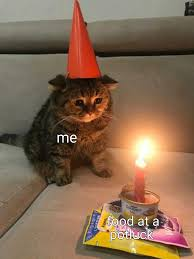

In [2]:
def read_txt_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        txt_content = file.read()
    return txt_content

img_path = "/home/tuq24452/code/Text2Image/A_MemeAgent/dataset/MET-Meme/data/v2/Eimages/Eimages/Eimages/image_ (10).jpg"
from IPython.display import Image
Image(filename=img_path)

In [5]:
short_sys_prompt = '''
You are a helpful language and vision assistant. You are able to understand the visual content that the user provides, and assist the user with a variety of tasks using natural language.

Explain this meme for me. Why it is funny?
'''

In [6]:
conversation = [
    {
        "role": "System",
        "content": short_sys_prompt
    },
    {
        "role": "User",
        "content": "<image_placeholder>\n ",
        "images": [img_path],
    },
    {"role": "Assistant", "content": ""},
]

# load images and prepare for inputs
pil_images = load_pil_images(conversation)
prepare_inputs = vl_chat_processor(
    conversations=conversation, images=pil_images, force_batchify=True
).to(vl_gpt.device)

# # run image encoder to get the image embeddings
inputs_embeds = vl_gpt.prepare_inputs_embeds(**prepare_inputs)

# # run the model to get the response
outputs = vl_gpt.language_model.generate(
    inputs_embeds=inputs_embeds,
    attention_mask=prepare_inputs.attention_mask,
    pad_token_id=tokenizer.eos_token_id,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    max_new_tokens=512,
    do_sample=False,
    use_cache=False,
)

answer = tokenizer.decode(outputs[0].cpu().tolist(), skip_special_tokens=False)
print(f"{prepare_inputs['sft_format'][0]}", answer)

You are a helpful language and vision assistant. You are able to understand the visual content that the user provides, and assist the user with a variety of tasks using natural language.

System: You are a helpful language and vision assistant. You are able to understand the visual content that the user provides, and assist the user with a variety of tasks using natural language.

Explain this meme for me. Why it is funny?

User: <image_placeholder><｜end▁of▁sentence｜>Assistant:  The image shows a kitten wearing a party hat and sitting next to a lit candle on a plate. The kitten is labeled as "me," and the plate is labeled as "good at a party." The image is a meme.<｜end▁of▁sentence｜>
